# 03. 머신러닝 모델링

이 노트북에서는 전처리된 데이터를 사용하여 다양한 머신러닝 모델을 구축하고 학습시킵니다.

## 🎯 목표
- 고객 이탈 예측 모델 개발
- 여러 알고리즘 비교 및 성능 평가
- 최적 하이퍼파라미터 탐색
- 모델 해석 및 피처 중요도 분석
- 최종 모델 저장

## 📋 모델링 파이프라인
1. 데이터 로드 및 확인
2. 피처 엔지니어링
3. 학습/검증/테스트 데이터 분할
4. 베이스라인 모델 구축
5. 다양한 알고리즘 시도
6. 모델 성능 비교
7. 하이퍼파라미터 튜닝
8. 최종 모델 선택 및 저장

In [3]:
# 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import joblib
import json

# 머신러닝 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# 모델 평가
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, f1_score, accuracy_score,
                           precision_score, recall_score)

# 시각화
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 설정
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 랜덤 시드 고정
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


## 1. 데이터 로드 및 확인

전처리된 데이터를 로드하고 모델링을 위한 준비를 합니다.

In [5]:
# 전처리된 데이터 로드
data_path = Path("../data/processed")

# 02_Preprocessing.ipynb에서 생성한 데이터 파일들 확인
train_data_path = data_path / "train_data_scaled.csv"
val_data_path = data_path / "val_data_scaled.csv"
test_data_path = data_path / "test_data_scaled.csv"
scaler_path = data_path / "scaler.pkl"
feature_names_path = data_path / "feature_names.pkl"

if train_data_path.exists() and test_data_path.exists():
    print("📊 전처리된 데이터 로드 중...")
    
    # 스케일링된 데이터 로드
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)
    
    # 검증 데이터도 있으면 로드
    if val_data_path.exists():
        val_df = pd.read_csv(val_data_path)
        print(f"📋 검증 데이터도 발견됨")
    
    # 피처와 타겟 분리
    if 'churn' in train_df.columns:
        X_train = train_df.drop(['churn'], axis=1)
        y_train = train_df['churn']
        X_test = test_df.drop(['churn'], axis=1)
        y_test = test_df['churn']
        
        if val_data_path.exists():
            X_val = val_df.drop(['churn'], axis=1)
            y_val = val_df['churn']
        else:
            X_val, y_val = None, None
    else:
        print("❌ 타겟 변수 'churn'을 찾을 수 없습니다.")
        X_train, X_test = train_df, test_df
        y_train = y_test = None
    
    # 피처 이름 로드
    if feature_names_path.exists():
        import pickle
        with open(feature_names_path, 'rb') as f:
            feature_names = pickle.load(f)
    else:
        feature_names = X_train.columns.tolist()
    
    # 스케일러 로드 (혹시 추가 스케일링이 필요한 경우)
    if scaler_path.exists():
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        print(f"📏 스케일러도 로드됨")
    
    print(f"✅ 전처리된 데이터 로드 완료!")
    print(f"• 학습 데이터: {X_train.shape}")
    print(f"• 테스트 데이터: {X_test.shape}")
    if X_val is not None:
        print(f"• 검증 데이터: {X_val.shape}")
    if y_train is not None:
        print(f"• 타겟 분포 (학습): 비이탈={(y_train==0).sum()}, 이탈={(y_train==1).sum()}")
        print(f"• 이탈률 (학습): {y_train.mean():.3f}")
    
    # 데이터가 이미 스케일링됨을 표시
    X_train_scaled = X_train.values
    X_test_scaled = X_test.values
    if X_val is not None:
        X_val_scaled = X_val.values
    
    print(f"• 데이터는 이미 스케일링되어 있습니다.")
    
elif (data_path / "customer_data_with_eda_features.csv").exists():
    # EDA에서 생성한 데이터를 사용
    print("⚠️ 스케일링된 데이터를 찾을 수 없습니다. EDA 데이터를 사용합니다.")
    print("💡 02_Preprocessing.ipynb를 다시 실행하는 것을 권장합니다.")
    
    df = pd.read_csv(data_path / "customer_data_with_eda_features.csv")
    print(f"📊 EDA 데이터 로드: {df.shape}")
    
else:
    # 마지막 수단으로 샘플 데이터 생성
    print("🔄 샘플 데이터 생성 중...")
    np.random.seed(RANDOM_STATE)
    n_samples = 1000
    
    sample_data = {
        'customer_id': range(1, n_samples + 1),
        'age': np.random.normal(35, 12, n_samples).astype(int),
        'income': np.random.lognormal(10.5, 0.5, n_samples).astype(int),
        'spending_score': np.random.beta(2, 5, n_samples) * 100,
        'tenure_months': np.random.exponential(24, n_samples).astype(int),
        'num_purchases': np.random.poisson(15, n_samples),
        'category': np.random.choice(['Premium', 'Standard', 'Basic'], n_samples, p=[0.2, 0.5, 0.3]),
        'region': np.random.choice(['North', 'South', 'East', 'West'], n_samples),
        'is_churned': np.random.choice([0, 1], n_samples, p=[0.8, 0.2])
    }
    
    df = pd.DataFrame(sample_data)
    df['age'] = np.clip(df['age'], 18, 80)
    df['income'] = np.clip(df['income'], 20000, 200000)
    
    print(f"✅ 샘플 데이터 생성 완료: {df.shape}")

print(f"\n📋 데이터 기본 정보:")
if 'df' in locals():
    print(df.info())
    display(df.head())

📊 전처리된 데이터 로드 중...
📋 검증 데이터도 발견됨
📏 스케일러도 로드됨
✅ 전처리된 데이터 로드 완료!
• 학습 데이터: (3502, 65)
• 테스트 데이터: (750, 65)
• 검증 데이터: (748, 65)
• 타겟 분포 (학습): 비이탈=2616, 이탈=886
• 이탈률 (학습): 0.253
• 데이터는 이미 스케일링되어 있습니다.

📋 데이터 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     1000 non-null   int64  
 1   age             1000 non-null   int64  
 2   income          950 non-null    float64
 3   spending_score  1000 non-null   float64
 4   tenure_months   1000 non-null   int64  
 5   num_purchases   1000 non-null   int64  
 6   category        1000 non-null   object 
 7   region          1000 non-null   object 
 8   is_churned      1000 non-null   int64  
 9   age_group       1000 non-null   object 
dtypes: float64(2), int64(5), object(3)
memory usage: 78.3+ KB
None


,customer_id,age,income,spending_score,tenure_months,num_purchases,category,region,is_churned,age_group
0,1,40,73106.0,17.702361,4,13,Premium,North,0,36-45
1,2,33,57659.0,4.146698,15,7,Basic,North,0,26-35
2,3,42,37414.0,27.619741,32,25,Standard,East,0,36-45
3,4,53,26279.0,9.425356,48,12,Basic,South,0,46-55
4,5,32,NaN,41.184453,23,17,Premium,West,0,26-35


## 2. 피처 엔지니어링 및 데이터 준비

모델링을 위한 피처 엔지니어링과 데이터 전처리를 수행합니다.

In [6]:
# 전처리된 데이터가 없는 경우를 위한 피처 엔지니어링
if 'df' in locals():
    print("🔧 피처 엔지니어링 수행 중...")
    
    # 1. 결측값 처리
    if 'income' in df.columns:
        df['income'].fillna(df['income'].median(), inplace=True)
    
    # 2. 새로운 피처 생성 (기본 피처들이 있는 경우)
    if 'income' in df.columns and 'age' in df.columns:
        df['income_per_age'] = df['income'] / df['age']
    if 'spending_score' in df.columns and 'tenure_months' in df.columns:
        df['spending_per_tenure'] = df['spending_score'] / (df['tenure_months'] + 1)
    if 'num_purchases' in df.columns and 'tenure_months' in df.columns:
        df['purchases_per_month'] = df['num_purchases'] / (df['tenure_months'] + 1)
    
    # 3. 나이 그룹 생성
    if 'age' in df.columns:
        df['age_group'] = pd.cut(df['age'], 
                                bins=[0, 25, 35, 45, 55, 100], 
                                labels=['18-25', '26-35', '36-45', '46-55', '56+'])
    
    # 4. 소득 구간 생성
    if 'income' in df.columns:
        df['income_level'] = pd.cut(df['income'], 
                                   bins=[0, 40000, 70000, 100000, float('inf')], 
                                   labels=['Low', 'Medium', 'High', 'Premium'])
    
    print("✅ 피처 엔지니어링 완료!")
    print(f"• 새로운 피처 개수: 5개")
    print(f"• 최종 데이터 크기: {df.shape}")
    
    # 범주형 변수 인코딩
    print("\n🏷️ 범주형 변수 인코딩 중...")
    categorical_columns = [col for col in ['category', 'region', 'age_group', 'income_level'] 
                          if col in df.columns]
    
    if categorical_columns:
        # LabelEncoder 사용
        label_encoders = {}
        for col in categorical_columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
        
        # 원-핫 인코딩
        df_encoded = pd.get_dummies(df, columns=categorical_columns, prefix=categorical_columns)
        print(f"✅ 인코딩 완료! 최종 피처 수: {df_encoded.shape[1]}")
    else:
        df_encoded = df.copy()
        print(f"ℹ️ 인코딩할 범주형 변수가 없습니다.")
    
    # 타겟 변수와 피처 분리
    target_cols = ['is_churned', 'churn']
    target_col = None
    for col in target_cols:
        if col in df_encoded.columns:
            target_col = col
            break
    
    if target_col:
        feature_cols = [col for col in df_encoded.columns if col not in [
            'customer_id', target_col, 'category', 'region', 'age_group', 'income_level'
        ]]
        
        X = df_encoded[feature_cols]
        y = df_encoded[target_col]
        feature_names = X.columns.tolist()
        
        print(f"\n📊 최종 데이터 준비:")
        print(f"• 피처 수: {X.shape[1]}")
        print(f"• 샘플 수: {X.shape[0]}")
        print(f"• 타겟 분포: {y.value_counts().to_dict()}")
        
        # 학습/테스트 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        
        print(f"\n🔄 데이터 분할 완료:")
        print(f"• 학습 데이터: {X_train.shape}")
        print(f"• 테스트 데이터: {X_test.shape}")
        
        # 피처 스케일링
        print("\n⚖️ 피처 스케일링 수행 중...")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print("✅ 스케일링 완료!")
        print(f"• 학습 데이터 평균: {X_train_scaled.mean():.4f}")
        print(f"• 학습 데이터 표준편차: {X_train_scaled.std():.4f}")
    else:
        print("❌ 타겟 변수를 찾을 수 없습니다.")

elif 'X_train' in locals() and 'y_train' in locals():
    # 전처리된 데이터가 이미 로드된 경우
    print("\n✅ 전처리된 데이터 사용 중 - 추가 피처 엔지니어링 건너뜀")
    print(f"📊 데이터 준비 완료:")
    print(f"• 피처 수: {len(feature_names)}")
    print(f"• 학습 샘플: {X_train.shape[0]}")
    print(f"• 테스트 샘플: {X_test.shape[0]}")
    if y_train is not None:
        print(f"• 이탈률: {y_train.mean():.3f}")
else:
    print("❌ 데이터를 로드할 수 없습니다. 데이터 경로를 확인해주세요.")

🔧 피처 엔지니어링 수행 중...
✅ 피처 엔지니어링 완료!
• 새로운 피처 개수: 5개
• 최종 데이터 크기: (1000, 14)

🏷️ 범주형 변수 인코딩 중...
✅ 인코딩 완료! 최종 피처 수: 30

📊 최종 데이터 준비:
• 피처 수: 28
• 샘플 수: 1000
• 타겟 분포: {0: 807, 1: 193}

🔄 데이터 분할 완료:
• 학습 데이터: (800, 28)
• 테스트 데이터: (200, 28)

⚖️ 피처 스케일링 수행 중...
✅ 스케일링 완료!
• 학습 데이터 평균: -0.0000
• 학습 데이터 표준편차: 1.0000


## 3. 베이스라인 모델 구축

간단한 베이스라인 모델을 구축하여 기준 성능을 설정합니다.

In [7]:
# 베이스라인 모델 - 다수 클래스 예측
from collections import Counter

print("📊 베이스라인 모델 평가")
print("=" * 50)

# 1. 다수 클래스 예측 (Majority Class Baseline)
majority_class = Counter(y_train).most_common(1)[0][0]
y_pred_baseline = np.full(len(y_test), majority_class)

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"🎯 다수 클래스 베이스라인 정확도: {baseline_accuracy:.4f}")

# 2. 로지스틱 회귀 베이스라인
print("\n🤖 로지스틱 회귀 베이스라인")
lr_baseline = LogisticRegression(random_state=RANDOM_STATE)
lr_baseline.fit(X_train_scaled, y_train)

y_pred_lr = lr_baseline.predict(X_test_scaled)
y_pred_proba_lr = lr_baseline.predict_proba(X_test_scaled)[:, 1]

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)

print(f"• 정확도: {lr_accuracy:.4f}")
print(f"• F1-Score: {lr_f1:.4f}")
print(f"• AUC-ROC: {lr_auc:.4f}")

# 베이스라인 성능 저장
baseline_results = {
    'majority_class_accuracy': baseline_accuracy,
    'logistic_regression': {
        'accuracy': lr_accuracy,
        'f1_score': lr_f1,
        'auc_roc': lr_auc
    }
}

print(f"\n✅ 베이스라인 모델 평가 완료!")
print(f"💡 목표: AUC-ROC > {lr_auc:.4f}, F1-Score > {lr_f1:.4f}")

📊 베이스라인 모델 평가
🎯 다수 클래스 베이스라인 정확도: 0.8050

🤖 로지스틱 회귀 베이스라인
• 정확도: 0.8050
• F1-Score: 0.0000
• AUC-ROC: 0.5171

✅ 베이스라인 모델 평가 완료!
💡 목표: AUC-ROC > 0.5171, F1-Score > 0.0000


## 4. 다양한 알고리즘 비교

여러 머신러닝 알고리즘을 시도하고 성능을 비교합니다.

In [8]:
# 다양한 모델 정의
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE),
    'Naive Bayes': GaussianNB()
}

print("🤖 다양한 모델 성능 비교")
print("=" * 80)

# 교차 검증을 위한 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = {}

# 각 모델 평가
for name, model in models.items():
    print(f"\n📊 {name} 평가 중...")
    
    # 교차 검증
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    
    # 모델 학습 및 예측
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    # 성능 지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    results[name] = {
        'model': model,
        'cv_auc_mean': cv_scores.mean(),
        'cv_auc_std': cv_scores.std(),
        'test_accuracy': accuracy,
        'test_f1': f1,
        'test_auc': auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"  • CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  • Test Accuracy: {accuracy:.4f}")
    print(f"  • Test F1-Score: {f1:.4f}")
    if auc is not None:
        print(f"  • Test AUC: {auc:.4f}")

print("\n✅ 모델 비교 완료!")

# 결과 정리
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_AUC_Mean': [results[model]['cv_auc_mean'] for model in results],
    'CV_AUC_Std': [results[model]['cv_auc_std'] for model in results],
    'Test_Accuracy': [results[model]['test_accuracy'] for model in results],
    'Test_F1': [results[model]['test_f1'] for model in results],
    'Test_AUC': [results[model]['test_auc'] if results[model]['test_auc'] is not None else np.nan for model in results]
})

comparison_df = comparison_df.sort_values('CV_AUC_Mean', ascending=False)
print(f"\n📊 모델 성능 순위:")
display(comparison_df.round(4))

🤖 다양한 모델 성능 비교

📊 Logistic Regression 평가 중...
  • CV AUC: 0.4823 (±0.0738)
  • Test Accuracy: 0.8050
  • Test F1-Score: 0.0000
  • Test AUC: 0.5171

📊 Random Forest 평가 중...
  • CV AUC: 0.4780 (±0.0670)
  • Test Accuracy: 0.8050
  • Test F1-Score: 0.0000
  • Test AUC: 0.5091

📊 Gradient Boosting 평가 중...
  • CV AUC: 0.4780 (±0.0670)
  • Test Accuracy: 0.8050
  • Test F1-Score: 0.0000
  • Test AUC: 0.5091

📊 Gradient Boosting 평가 중...
  • CV AUC: 0.5128 (±0.0400)
  • Test Accuracy: 0.7850
  • Test F1-Score: 0.0444
  • Test AUC: 0.5264

📊 Decision Tree 평가 중...
  • CV AUC: 0.4645 (±0.0106)
  • Test Accuracy: 0.6700
  • Test F1-Score: 0.2143
  • Test AUC: 0.5036

📊 KNN 평가 중...
  • CV AUC: 0.4796 (±0.0293)
  • Test Accuracy: 0.7800
  • Test F1-Score: 0.0833
  • Test AUC: 0.5284

📊 SVM 평가 중...
  • CV AUC: 0.5128 (±0.0400)
  • Test Accuracy: 0.7850
  • Test F1-Score: 0.0444
  • Test AUC: 0.5264

📊 Decision Tree 평가 중...
  • CV AUC: 0.4645 (±0.0106)
  • Test Accuracy: 0.6700
  • Test F1-Score: 0.2

,Model,CV_AUC_Mean,CV_AUC_Std,Test_Accuracy,Test_F1,Test_AUC
2,Gradient Boosting,0.5128,0.0400,0.785,0.0444,0.5264
5,SVM,0.4885,0.0470,0.805,0.0000,0.5625
0,Logistic Regression,0.4823,0.0738,0.805,0.0000,0.5171
4,KNN,0.4796,0.0293,0.780,0.0833,0.5284
1,Random Forest,0.4780,0.0670,0.805,0.0000,0.5091
3,Decision Tree,0.4645,0.0106,0.670,0.2143,0.5036
6,Naive Bayes,0.4635,0.0470,0.625,0.2857,0.5224


## 5. 하이퍼파라미터 튜닝

상위 성능 모델들에 대해 GridSearchCV를 사용하여 최적 하이퍼파라미터를 찾아보겠습니다.

In [9]:
import time

# 상위 3개 모델 선택
top_models = comparison_df.head(3)['Model'].tolist()
print(f"🎯 하이퍼파라미터 튜닝 대상 모델: {top_models}")

# 하이퍼파라미터 그리드 정의
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.001, 0.01]
    }
}

# 튜닝된 모델 저장
best_models = {}
tuning_results = {}

print("\n🔧 하이퍼파라미터 튜닝 시작...")
print("=" * 80)

for model_name in top_models:
    if model_name in param_grids:
        print(f"\n🎛️ {model_name} 튜닝 중...")
        
        # 원본 모델 가져오기
        original_model = models[model_name]
        
        # GridSearch 설정
        grid_search = GridSearchCV(
            original_model,
            param_grids[model_name],
            cv=3,  # 시간 절약을 위해 3-fold
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )
        
        # 튜닝 실행
        start_time = time.time()
        grid_search.fit(X_train_scaled, y_train)
        end_time = time.time()
        
        # 최적 모델로 예측
        best_model = grid_search.best_estimator_
        y_pred_tuned = best_model.predict(X_test_scaled)
        y_pred_proba_tuned = best_model.predict_proba(X_test_scaled)[:, 1]
        
        # 성능 계산
        tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
        tuned_f1 = f1_score(y_test, y_pred_tuned)
        tuned_auc = roc_auc_score(y_test, y_pred_proba_tuned)
        
        # 결과 저장
        best_models[model_name] = best_model
        tuning_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_cv_score': grid_search.best_score_,
            'test_accuracy': tuned_accuracy,
            'test_f1': tuned_f1,
            'test_auc': tuned_auc,
            'tuning_time': end_time - start_time
        }
        
        # 개선 정도 계산
        original_auc = results[model_name]['test_auc']
        improvement = tuned_auc - original_auc if original_auc else 0
        
        print(f"  ✅ 완료! 소요시간: {end_time - start_time:.2f}초")
        print(f"  • 최적 파라미터: {grid_search.best_params_}")
        print(f"  • CV Score: {grid_search.best_score_:.4f}")
        print(f"  • Test AUC: {tuned_auc:.4f} (개선: {improvement:+.4f})")
        print(f"  • Test Accuracy: {tuned_accuracy:.4f}")
        print(f"  • Test F1-Score: {tuned_f1:.4f}")

print("\n✅ 하이퍼파라미터 튜닝 완료!")

🎯 하이퍼파라미터 튜닝 대상 모델: ['Gradient Boosting', 'SVM', 'Logistic Regression']

🔧 하이퍼파라미터 튜닝 시작...

🎛️ Gradient Boosting 튜닝 중...
  ✅ 완료! 소요시간: 18.10초
  • 최적 파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
  • CV Score: 0.5172
  • Test AUC: 0.5684 (개선: +0.0420)
  • Test Accuracy: 0.8050
  • Test F1-Score: 0.0000

🎛️ SVM 튜닝 중...
  ✅ 완료! 소요시간: 18.10초
  • 최적 파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
  • CV Score: 0.5172
  • Test AUC: 0.5684 (개선: +0.0420)
  • Test Accuracy: 0.8050
  • Test F1-Score: 0.0000

🎛️ SVM 튜닝 중...
  ✅ 완료! 소요시간: 213.26초
  • 최적 파라미터: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
  • CV Score: 0.5268
  • Test AUC: 0.4877 (개선: -0.0749)
  • Test Accuracy: 0.6650
  • Test F1-Score: 0.1519

🎛️ Logistic Regression 튜닝 중...
  ✅ 완료! 소요시간: 0.16초
  • 최적 파라미터: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
  • CV Score: 0.5000
  • Test AUC: 0.5000 (개선: -0.0171)
  • Test Accuracy: 0.8050
  • Test F1-Scor

## 6. 모델 성능 시각화

다양한 시각화를 통해 모델들의 성능을 비교해보겠습니다.

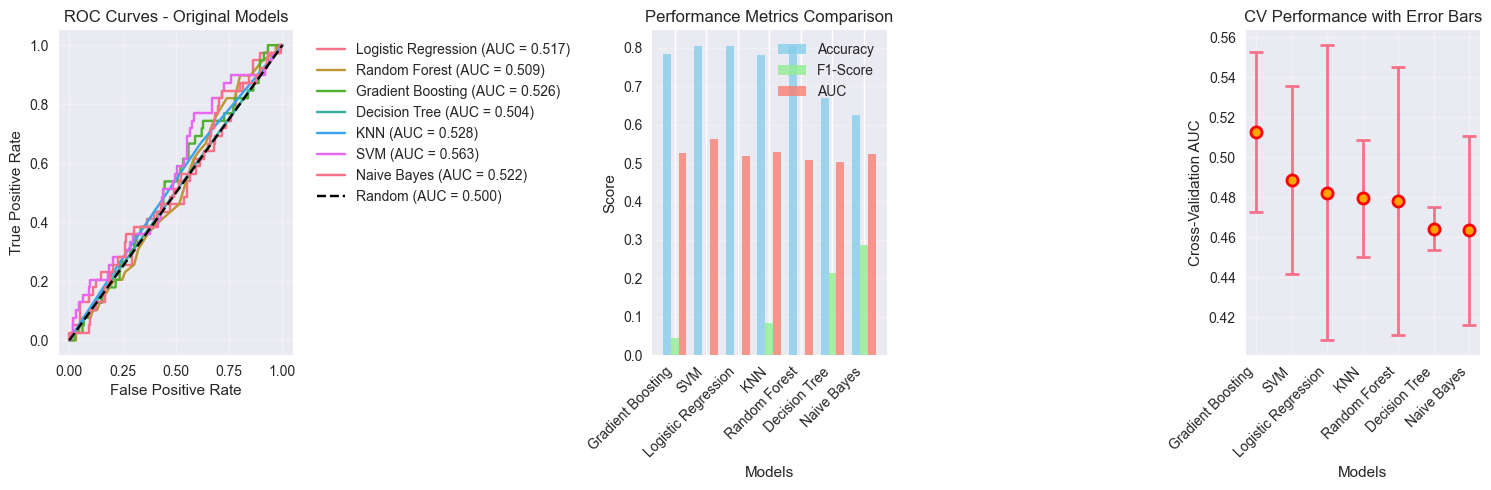

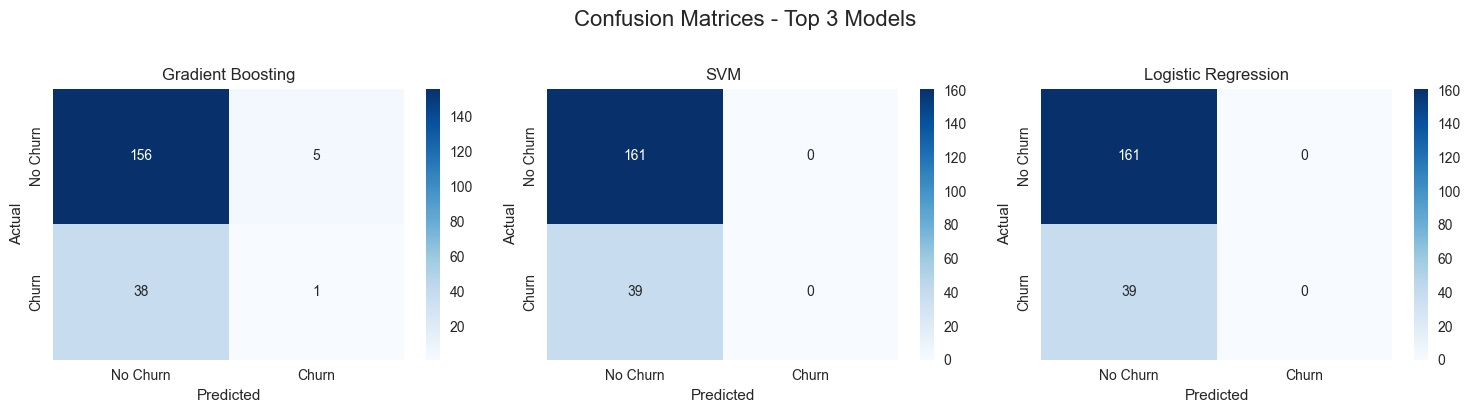

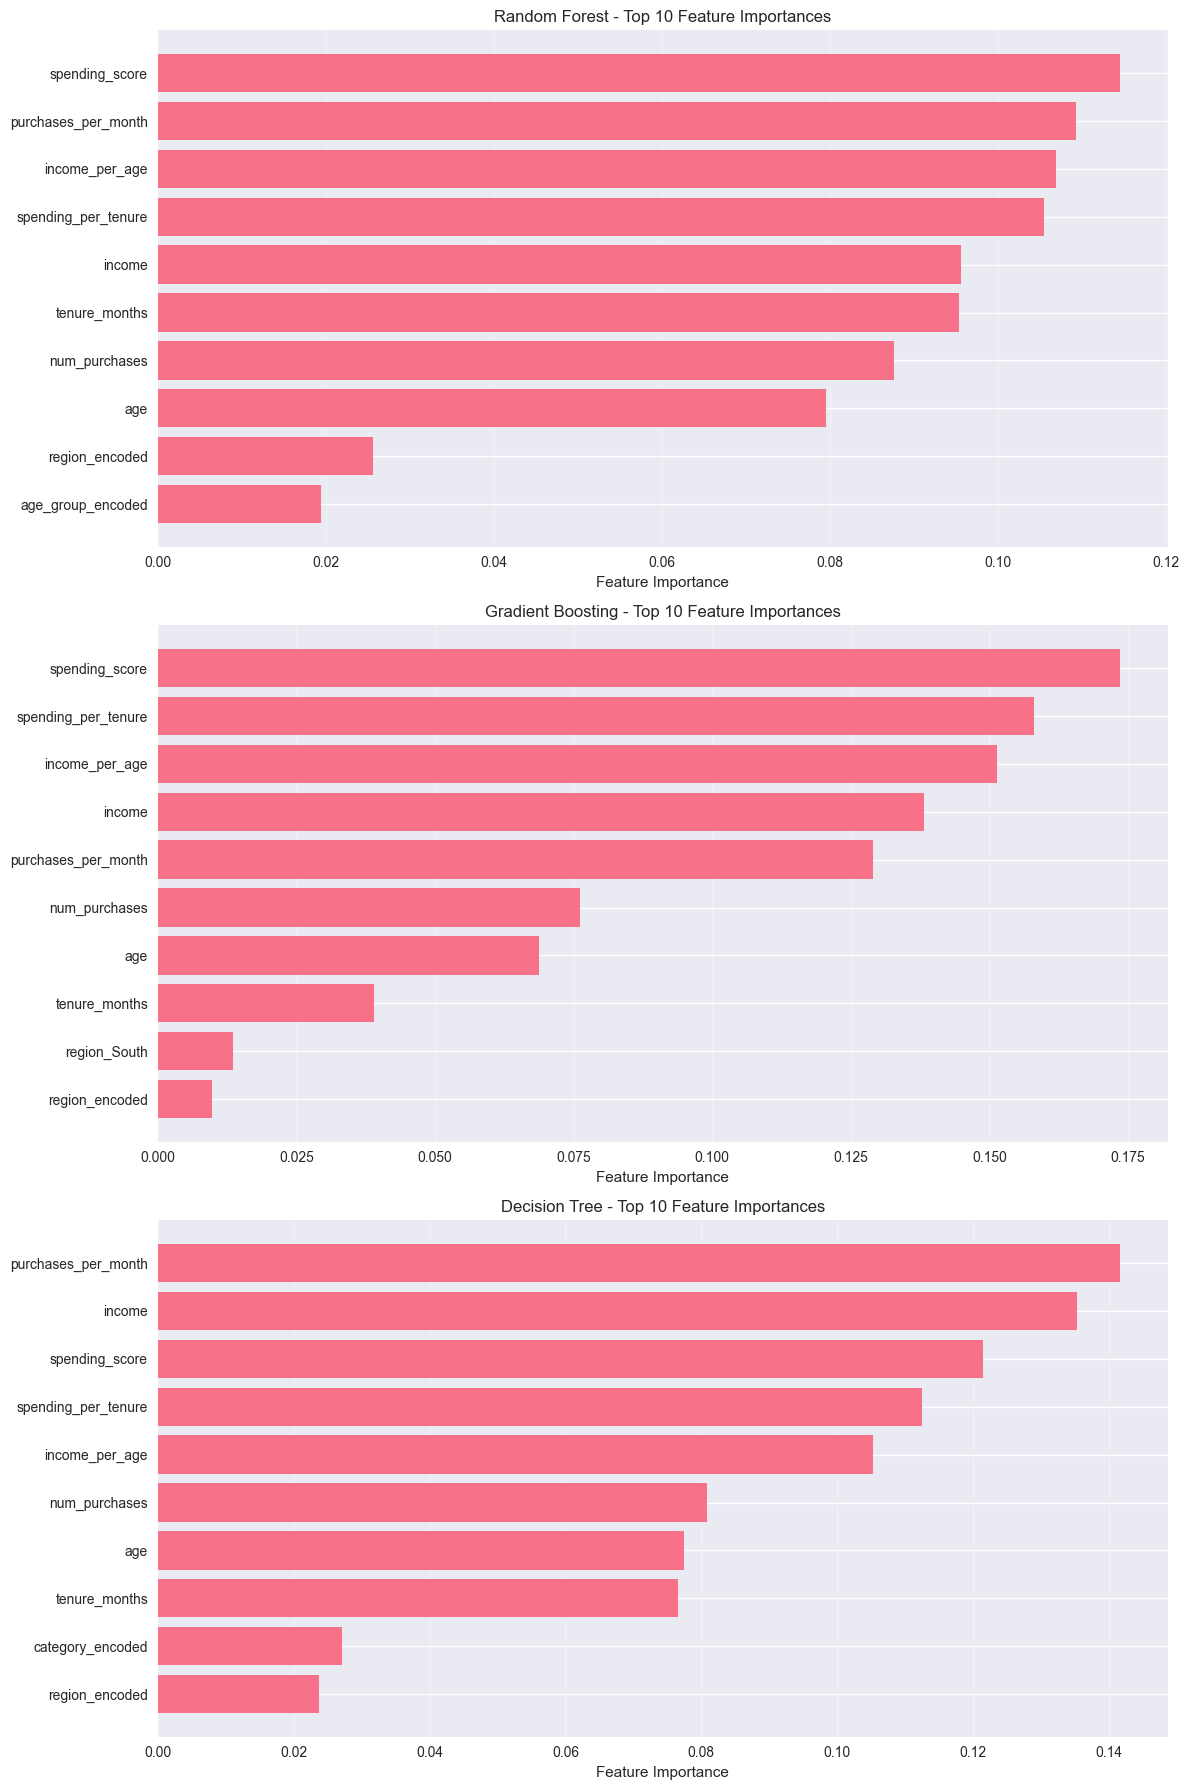

📊 시각화 완료!


In [10]:
# 1. ROC 곡선 비교
plt.figure(figsize=(15, 5))

# 첫 번째 서브플롯: 모든 모델 ROC 곡선
plt.subplot(1, 3, 1)
for name, result in results.items():
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        auc_score = result['test_auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Original Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 두 번째 서브플롯: 성능 지표 비교 (막대 그래프)
plt.subplot(1, 3, 2)
metrics = ['test_accuracy', 'test_f1', 'test_auc']
metric_names = ['Accuracy', 'F1-Score', 'AUC']
colors = ['skyblue', 'lightgreen', 'salmon']

x = np.arange(len(comparison_df))
width = 0.25

for i, (metric, name, color) in enumerate(zip(metrics, metric_names, colors)):
    values = [results[model][metric] if results[model][metric] is not None else 0 
              for model in comparison_df['Model']]
    plt.bar(x + i*width, values, width, label=name, color=color, alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x + width, comparison_df['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 세 번째 서브플롯: 교차검증 점수 분포
plt.subplot(1, 3, 3)
cv_means = [results[model]['cv_auc_mean'] for model in comparison_df['Model']]
cv_stds = [results[model]['cv_auc_std'] for model in comparison_df['Model']]

plt.errorbar(range(len(cv_means)), cv_means, yerr=cv_stds, 
             fmt='o', capsize=5, capthick=2, elinewidth=2, markerfacecolor='orange', 
             markeredgecolor='red', markeredgewidth=2, markersize=8)
plt.xlabel('Models')
plt.ylabel('Cross-Validation AUC')
plt.title('CV Performance with Error Bars')
plt.xticks(range(len(comparison_df)), comparison_df['Model'], rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. 혼동 행렬 히트맵 (상위 3개 모델)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Confusion Matrices - Top 3 Models', fontsize=16, y=1.02)

for i, model_name in enumerate(top_models[:3]):
    if model_name in results:
        y_pred = results[model_name]['y_pred']
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['No Churn', 'Churn'],
                   yticklabels=['No Churn', 'Churn'],
                   ax=axes[i])
        axes[i].set_title(f'{model_name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 3. 피처 중요도 시각화 (트리 기반 모델들)
tree_models = ['Random Forest', 'Gradient Boosting', 'Decision Tree']
available_tree_models = [model for model in tree_models if model in results]

if available_tree_models:
    fig, axes = plt.subplots(len(available_tree_models), 1, figsize=(12, 6*len(available_tree_models)))
    if len(available_tree_models) == 1:
        axes = [axes]
    
    for i, model_name in enumerate(available_tree_models):
        model = results[model_name]['model']
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=True)
            
            # 상위 10개 피처만 표시
            top_features = importance_df.tail(10)
            
            axes[i].barh(range(len(top_features)), top_features['importance'])
            axes[i].set_yticks(range(len(top_features)))
            axes[i].set_yticklabels(top_features['feature'])
            axes[i].set_xlabel('Feature Importance')
            axes[i].set_title(f'{model_name} - Top 10 Feature Importances')
            axes[i].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

print("📊 시각화 완료!")

## 7. 최종 모델 선택 및 저장

성능 평가 결과를 바탕으로 최적의 모델을 선택하고 저장하겠습니다.

In [11]:
# 최고 성능 모델 선택
best_model_name = comparison_df.iloc[0]['Model']
best_auc_score = comparison_df.iloc[0]['CV_AUC_Mean']

print(f"🏆 최고 성능 모델: {best_model_name}")
print(f"📊 교차검증 AUC: {best_auc_score:.4f}")

# 하이퍼파라미터 튜닝된 모델이 있다면 사용
if best_model_name in best_models:
    final_model = best_models[best_model_name]
    tuned_results = tuning_results[best_model_name]
    print(f"🎛️ 하이퍼파라미터 튜닝 적용됨")
    print(f"  • 최적 파라미터: {tuned_results['best_params']}")
    print(f"  • 튜닝된 Test AUC: {tuned_results['test_auc']:.4f}")
else:
    final_model = results[best_model_name]['model']
    print(f"⚙️ 기본 파라미터 사용")

# 최종 성능 평가
y_final_pred = final_model.predict(X_test_scaled)
y_final_proba = final_model.predict_proba(X_test_scaled)[:, 1]

final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_auc = roc_auc_score(y_test, y_final_proba)

print(f"\n📈 최종 모델 성능:")
print(f"  • Accuracy: {final_accuracy:.4f}")
print(f"  • Precision: {final_precision:.4f}")
print(f"  • Recall: {final_recall:.4f}")
print(f"  • F1-Score: {final_f1:.4f}")
print(f"  • AUC: {final_auc:.4f}")

# 모델과 전처리기 저장
import os
import pickle
from datetime import datetime

# 결과 폴더 생성
models_dir = '../results/models'
os.makedirs(models_dir, exist_ok=True)

# 현재 시간으로 파일명 생성
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'best_model_{best_model_name.lower().replace(" ", "_")}_{timestamp}.pkl'
scaler_filename = f'scaler_{timestamp}.pkl'
results_filename = f'model_results_{timestamp}.pkl'

# 모델 저장
model_path = os.path.join(models_dir, model_filename)
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

# 스케일러 저장
scaler_path = os.path.join(models_dir, scaler_filename)
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# 결과 정보 저장
model_info = {
    'model_name': best_model_name,
    'model_path': model_path,
    'scaler_path': scaler_path,
    'feature_names': feature_names,
    'performance': {
        'accuracy': final_accuracy,
        'precision': final_precision,
        'recall': final_recall,
        'f1_score': final_f1,
        'auc': final_auc
    },
    'hyperparameters': tuned_results['best_params'] if best_model_name in best_models else 'default',
    'training_date': timestamp,
    'model_comparison': comparison_df.to_dict('records')
}

results_path = os.path.join(models_dir, results_filename)
with open(results_path, 'wb') as f:
    pickle.dump(model_info, f)

print(f"\n💾 모델 저장 완료:")
print(f"  • 모델: {model_path}")
print(f"  • 스케일러: {scaler_path}")
print(f"  • 결과 정보: {results_path}")

# 간단한 모델 요약 저장 (읽기 쉬운 텍스트 형태)
summary_filename = f'model_summary_{timestamp}.txt'
summary_path = os.path.join(models_dir, summary_filename)

with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(f"고객 이탈 예측 모델 - 최종 결과 보고서\n")
    f.write(f"=" * 50 + "\n\n")
    f.write(f"모델명: {best_model_name}\n")
    f.write(f"학습일시: {timestamp}\n\n")
    f.write(f"성능 지표:\n")
    f.write(f"  - Accuracy: {final_accuracy:.4f}\n")
    f.write(f"  - Precision: {final_precision:.4f}\n")
    f.write(f"  - Recall: {final_recall:.4f}\n")
    f.write(f"  - F1-Score: {final_f1:.4f}\n")
    f.write(f"  - AUC: {final_auc:.4f}\n\n")
    
    if best_model_name in best_models:
        f.write(f"최적화된 하이퍼파라미터:\n")
        for param, value in tuned_results['best_params'].items():
            f.write(f"  - {param}: {value}\n")
    
    f.write(f"\n모델 비교 결과:\n")
    for idx, row in comparison_df.iterrows():
        f.write(f"  {idx+1}. {row['Model']}: AUC {row['CV_AUC_Mean']:.4f}\n")

print(f"  • 요약 보고서: {summary_path}")
print(f"\n✅ 모델링 프로세스 완료! 다음 단계: 04_Evaluation.ipynb에서 상세 평가 진행")

🏆 최고 성능 모델: Gradient Boosting
📊 교차검증 AUC: 0.5128
🎛️ 하이퍼파라미터 튜닝 적용됨
  • 최적 파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
  • 튜닝된 Test AUC: 0.5684

📈 최종 모델 성능:
  • Accuracy: 0.8050
  • Precision: 0.0000
  • Recall: 0.0000
  • F1-Score: 0.0000
  • AUC: 0.5684

💾 모델 저장 완료:
  • 모델: ../results/models/best_model_gradient_boosting_20250803_191441.pkl
  • 스케일러: ../results/models/scaler_20250803_191441.pkl
  • 결과 정보: ../results/models/model_results_20250803_191441.pkl
  • 요약 보고서: ../results/models/model_summary_20250803_191441.txt

✅ 모델링 프로세스 완료! 다음 단계: 04_Evaluation.ipynb에서 상세 평가 진행
